### Denoising Autoencoders And Where To Find Them (5 points)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [1]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.transpose([0,3,1,2]).astype('float32') / 256.0

img_shape = X.shape[1:]
print("Image shape:",img_shape)

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

Image shape: (3, 38, 38)


X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


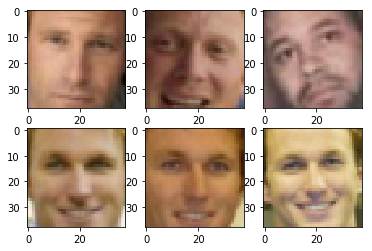

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [3]:
import theano,theano.tensor as T
import lasagne,lasagne.layers as L
def build_pca_autoencoder(img_shape,code_size=32):
    """
    Here we define a simple linear autoencoder as described above.
    We also reshape decoded data to be compatible with image shapes
    """
    inp = L.InputLayer((None,)+img_shape)
    enc = L.DenseLayer(inp,code_size,nonlinearity=None)
    
    dec = L.DenseLayer(enc,np.prod(img_shape),nonlinearity=None)  #actual decoder, height*width*3 units
    dec = L.ReshapeLayer(dec,(-1,)+img_shape)
    
    return inp,enc,dec

Meld them together into one model

In [4]:
inp, encoder, decoder = build_pca_autoencoder(img_shape,code_size=32)

code,reconstruction = L.get_output([encoder,decoder])
loss = T.mean((inp.input_var - reconstruction)**2)
updates = lasagne.updates.adamax(loss,L.get_all_params(decoder,trainable=True))

train_step = theano.function([inp.input_var],loss,updates=updates,allow_input_downcast=True)
compute_loss = theano.function([inp.input_var],loss,allow_input_downcast=True)
encode_decode = theano.function([inp.input_var],[code,reconstruction],allow_input_downcast=True)

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [5]:
from tqdm import tqdm
import sys
def iterate_minibatches(data, batch_size = 32,verbose = True):
    indices = np.random.permutation(np.arange(len(data)))
    batches = range(0, len(data), batch_size)
    if verbose: 
        batches = tqdm(batches)
    return (data[indices[start_idx:start_idx + batch_size]] for start_idx in batches)

In [6]:
for epoch in range(32):
    losses = []
    for x_batch in iterate_minibatches(X_train,batch_size=50):
        losses.append(train_step(x_batch))
    print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)
    
    val_losses = list(map(compute_loss,iterate_minibatches(X_test,verbose=False)))
    print("#%i, Test loss: %.7f"%(epoch+1,np.mean(val_losses)),flush=True)
    

100%|██████████| 237/237 [00:01<00:00, 129.97it/s]

#1, Train loss: 0.0333306


#1, Test loss: 0.0200711


100%|██████████| 237/237 [00:01<00:00, 128.07it/s]

#2, Train loss: 0.0187881
#2, Test loss: 0.0173167



100%|██████████| 237/237 [00:01<00:00, 135.12it/s]

#3, Train loss: 0.0158363


#3, Test loss: 0.0149332


100%|██████████| 237/237 [00:01<00:00, 126.78it/s]

#4, Train loss: 0.0138474


#4, Test loss: 0.0133196


100%|██████████| 237/237 [00:02<00:00, 106.67it/s]

#5, Train loss: 0.0123250
#5, Test loss: 0.0119035



100%|██████████| 237/237 [00:02<00:00, 110.16it/s]

#6, Train loss: 0.0111530


#6, Test loss: 0.0109083


100%|██████████| 237/237 [00:02<00:00, 111.51it/s]

#7, Train loss: 0.0102382
#7, Test loss: 0.0099314



100%|██████████| 237/237 [00:02<00:00, 108.04it/s]

#8, Train loss: 0.0094479


#8, Test loss: 0.0091870


100%|██████████| 237/237 [00:02<00:00, 102.75it/s]

#9, Train loss: 0.0087394
#9, Test loss: 0.0085877



100%|██████████| 237/237 [00:02<00:00, 114.18it/s]

#10, Train loss: 0.0080948


#10, Test loss: 0.0078919


100%|██████████| 237/237 [00:02<00:00, 111.37it/s]

#11, Train loss: 0.0075126
#11, Test loss: 0.0074237



100%|██████████| 237/237 [00:01<00:00, 121.46it/s]

#12, Train loss: 0.0069776


#12, Test loss: 0.0068836


100%|██████████| 237/237 [00:02<00:00, 114.35it/s]

#13, Train loss: 0.0064915


#13, Test loss: 0.0063741


100%|██████████| 237/237 [00:02<00:00, 102.80it/s]

#14, Train loss: 0.0060850
#14, Test loss: 0.0059836



100%|██████████| 237/237 [00:02<00:00, 94.32it/s]

#15, Train loss: 0.0057948


#15, Test loss: 0.0058384


100%|██████████| 237/237 [00:02<00:00, 95.36it/s]

#16, Train loss: 0.0056431


#16, Test loss: 0.0056545


100%|██████████| 237/237 [00:02<00:00, 108.70it/s]

#17, Train loss: 0.0056067


#17, Test loss: 0.0056950


100%|██████████| 237/237 [00:01<00:00, 120.12it/s]

#18, Train loss: 0.0055681


#18, Test loss: 0.0056299


100%|██████████| 237/237 [00:02<00:00, 116.07it/s]

#19, Train loss: 0.0055174


#19, Test loss: 0.0056051


100%|██████████| 237/237 [00:01<00:00, 121.76it/s]

#20, Train loss: 0.0055468


#20, Test loss: 0.0056113


100%|██████████| 237/237 [00:01<00:00, 122.56it/s]

#21, Train loss: 0.0055400


#21, Test loss: 0.0056388


100%|██████████| 237/237 [00:01<00:00, 128.64it/s]

#22, Train loss: 0.0055271


#22, Test loss: 0.0055970


100%|██████████| 237/237 [00:02<00:00, 117.66it/s]

#23, Train loss: 0.0055227


#23, Test loss: 0.0056764


100%|██████████| 237/237 [00:02<00:00, 115.62it/s]

#24, Train loss: 0.0055209


#24, Test loss: 0.0055303


100%|██████████| 237/237 [00:01<00:00, 134.44it/s]

#25, Train loss: 0.0055158


#25, Test loss: 0.0055450


100%|██████████| 237/237 [00:01<00:00, 136.60it/s]

#26, Train loss: 0.0054974
#26, Test loss: 0.0055511



100%|██████████| 237/237 [00:01<00:00, 136.00it/s]

#27, Train loss: 0.0054977
#27, Test loss: 0.0057195



100%|██████████| 237/237 [00:01<00:00, 125.63it/s]

#28, Train loss: 0.0055119
#28, Test loss: 0.0055742



100%|██████████| 237/237 [00:01<00:00, 133.16it/s]

#29, Train loss: 0.0054994


#29, Test loss: 0.0055913


100%|██████████| 237/237 [00:01<00:00, 133.97it/s]

#30, Train loss: 0.0055064
#30, Test loss: 0.0055652



100%|██████████| 237/237 [00:01<00:00, 138.34it/s]

#31, Train loss: 0.0054979


#31, Test loss: 0.0056339


100%|██████████| 237/237 [00:01<00:00, 137.92it/s]

#32, Train loss: 0.0054870


#32, Test loss: 0.0055634


In [7]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code,reco = encode_decode(img[None])

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.transpose([1,2,0]))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].transpose([1,2,0]).clip(0,1))
    plt.show()


Final MSE: 0.00561275001965


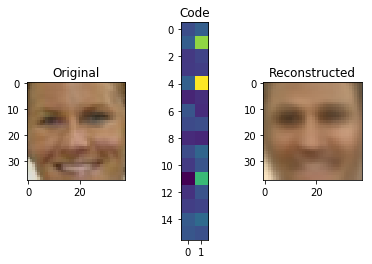

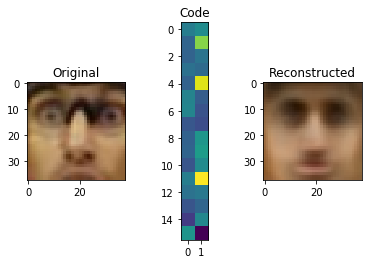

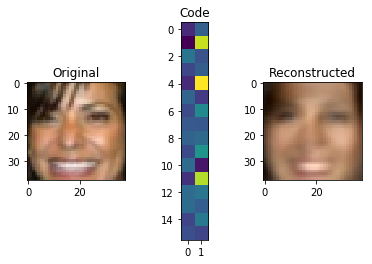

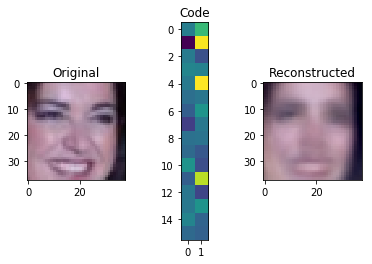

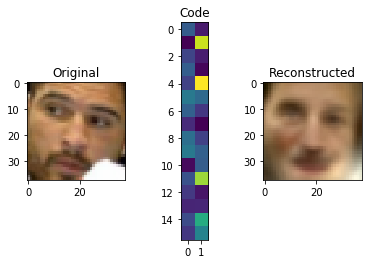

In [8]:
score = np.mean(list(map(compute_loss,iterate_minibatches(X_test,verbose=False))))
print("Final MSE:",score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [51]:
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    C,H,W = img_shape
    
    inp = L.InputLayer((None,)+img_shape)
    
    #enc_Conv_1 = L.Conv2DLayer(inp, num_filters = 16, filter_size = (2, 2),
    ##                           nonlinearity = None)
    
    #enc_Pool = L.Pool2DLayer(enc_Conv_1, pool_size = 3)
    
    #enc_Conv_2 = L.Conv2DLayer(enc_Pool, num_filters = 16, filter_size = (3, 3),
    #                           nonlinearity = None)
    
    enc_layer_1 = L.DenseLayer(inp, code_size * 16, nonlinearity=lasagne.nonlinearities.rectify)
    
    enc_norm_1 = L.BatchNormLayer(enc_layer_1)
    
    enc_layer_2 = L.DenseLayer(enc_norm_1, code_size * 8, nonlinearity = lasagne.nonlinearities.sigmoid)
    
    enc_norm_2 = L.BatchNormLayer(enc_layer_2)
    
    enc_layer_3 = L.DenseLayer(enc_norm_2, code_size * 4, nonlinearity= lasagne.nonlinearities.selu)
    
    enc_norm_3 = L.BatchNormLayer(enc_layer_3)
    
    enc_layer_4 = L.DenseLayer(enc_norm_3, code_size * 2, nonlinearity= lasagne.nonlinearities.elu)
    
    enc_norm_4 = L.BatchNormLayer(enc_layer_4)
    
    encoder = L.DenseLayer(enc_norm_4, code_size, nonlinearity=None)
    
    dec_layer_1 = L.NonlinearityLayer(encoder, nonlinearity=lasagne.nonlinearities.elu)
    
    dec_norm_1 = L.BatchNormLayer(dec_layer_1)
    
    dec_layer_2 = L.DenseLayer(dec_norm_1, code_size * 2, nonlinearity=lasagne.nonlinearities.elu)  #actual decoder, height*width*3 units
    
    dec_norm_2 = L.BatchNormLayer(dec_layer_2)
    
    dec_layer_3 = L.DenseLayer(dec_norm_2, code_size * 4, nonlinearity = lasagne.nonlinearities.selu)
    
    dec_norm_3 = L.BatchNormLayer(dec_layer_3)
    
    dec_layer_4 = L.DenseLayer(dec_norm_3, code_size * 8, nonlinearity=lasagne.nonlinearities.elu)  #actual decoder, height*width*3 units
    
    dec_norm_4 = L.BatchNormLayer(dec_layer_4)
    
    dec_layer_5 = L.DenseLayer(dec_norm_4, code_size * 16, nonlinearity = lasagne.nonlinearities.selu)
    
    dec_norm_5 = L.BatchNormLayer(dec_layer_5)
    
    decoder = L.DenseLayer(dec_norm_5, np.prod(img_shape), nonlinearity=lasagne.nonlinearities.elu)
    decoder = L.ReshapeLayer(decoder,(-1,)+img_shape)
    
    L.
    
    return inp,encoder,decoder

In [52]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    _,encoder,decoder = build_deep_autoencoder(img_shape,code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==img_shape,   "decoder must output an image of valid shape"
    assert len(L.get_all_params(decoder))>=6,       "encoder must contain at least 3 dense layers"
    
    for layer in L.get_all_layers(decoder):
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [53]:
inp, encoder, decoder = build_pca_autoencoder(img_shape,code_size=32)

code,reconstruction = L.get_output([encoder,decoder])
loss = T.mean((inp.input_var - reconstruction)**2)
updates = lasagne.updates.adamax(loss,L.get_all_params(decoder,trainable=True))

train_step = theano.function([inp.input_var],loss,updates=updates,allow_input_downcast=True)
compute_loss = theano.function([inp.input_var],loss,allow_input_downcast=True)
encode_decode = theano.function([inp.input_var],[code,reconstruction],allow_input_downcast=True)

Training may take long, it's okay.

In [54]:
for epoch in range(32):
    losses = []
    for x_batch in iterate_minibatches(X_train,batch_size=50):
        losses.append(train_step(x_batch))
    print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)
    
    val_losses = list(map(compute_loss,iterate_minibatches(X_test,verbose=False)))
    print("#%i, Test loss: %.7f"%(epoch+1,np.mean(val_losses)),flush=True)
    

100%|██████████| 237/237 [00:01<00:00, 131.77it/s]

#1, Train loss: 0.0331887


#1, Test loss: 0.0205248


100%|██████████| 237/237 [00:01<00:00, 132.90it/s]

#2, Train loss: 0.0191001


#2, Test loss: 0.0177927


100%|██████████| 237/237 [00:01<00:00, 135.06it/s]

#3, Train loss: 0.0161195


#3, Test loss: 0.0150058


100%|██████████| 237/237 [00:01<00:00, 121.95it/s]

#4, Train loss: 0.0139156


#4, Test loss: 0.0132882


100%|██████████| 237/237 [00:01<00:00, 136.36it/s]

#5, Train loss: 0.0123902


#5, Test loss: 0.0118933


100%|██████████| 237/237 [00:02<00:00, 95.79it/s]

#6, Train loss: 0.0112107


#6, Test loss: 0.0107958


100%|██████████| 237/237 [00:01<00:00, 122.88it/s]

#7, Train loss: 0.0102573


#7, Test loss: 0.0099876


100%|██████████| 237/237 [00:01<00:00, 134.80it/s]

#8, Train loss: 0.0094183


#8, Test loss: 0.0091370


100%|██████████| 237/237 [00:01<00:00, 138.06it/s]

#9, Train loss: 0.0086925


#9, Test loss: 0.0085096


100%|██████████| 237/237 [00:01<00:00, 135.90it/s]

#10, Train loss: 0.0080511


#10, Test loss: 0.0078431


100%|██████████| 237/237 [00:01<00:00, 133.70it/s]

#11, Train loss: 0.0074952


#11, Test loss: 0.0074036


100%|██████████| 237/237 [00:01<00:00, 124.95it/s]

#12, Train loss: 0.0070084


#12, Test loss: 0.0070682


100%|██████████| 237/237 [00:01<00:00, 133.89it/s]

#13, Train loss: 0.0065417
#13, Test loss: 0.0064181



100%|██████████| 237/237 [00:01<00:00, 138.02it/s]

#14, Train loss: 0.0061393


#14, Test loss: 0.0062686


100%|██████████| 237/237 [00:01<00:00, 134.87it/s]

#15, Train loss: 0.0058834


#15, Test loss: 0.0058782


100%|██████████| 237/237 [00:01<00:00, 127.58it/s]

#16, Train loss: 0.0056968


#16, Test loss: 0.0056638


100%|██████████| 237/237 [00:01<00:00, 133.17it/s]

#17, Train loss: 0.0056317
#17, Test loss: 0.0056545



100%|██████████| 237/237 [00:01<00:00, 132.66it/s]

#18, Train loss: 0.0055489


#18, Test loss: 0.0056905


100%|██████████| 237/237 [00:01<00:00, 135.90it/s]

#19, Train loss: 0.0055358
#19, Test loss: 0.0056236



100%|██████████| 237/237 [00:01<00:00, 137.83it/s]

#20, Train loss: 0.0055377


#20, Test loss: 0.0056557


100%|██████████| 237/237 [00:02<00:00, 87.05it/s]

#21, Train loss: 0.0055284


#21, Test loss: 0.0056676


100%|██████████| 237/237 [00:01<00:00, 121.32it/s]

#22, Train loss: 0.0055206


#22, Test loss: 0.0056304


100%|██████████| 237/237 [00:02<00:00, 102.47it/s]

#23, Train loss: 0.0055380


#23, Test loss: 0.0057485


100%|██████████| 237/237 [00:02<00:00, 106.34it/s]

#24, Train loss: 0.0055358
#24, Test loss: 0.0057192



100%|██████████| 237/237 [00:02<00:00, 101.16it/s]

#25, Train loss: 0.0055009
#25, Test loss: 0.0056974



100%|██████████| 237/237 [00:02<00:00, 117.25it/s]

#26, Train loss: 0.0055222
#26, Test loss: 0.0056238



 33%|███▎      | 79/237 [00:00<00:01, 126.97it/s]


KeyboardInterrupt: 

In [15]:
reconstruction_mse = np.mean(list(map(compute_loss,iterate_minibatches(X_test,verbose=False))))
assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
assert len(encoder.output_shape)==2 and encoder.output_shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

AssertionError: Compression is too lossy. See tips below.

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [15]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    noise = np.random.normal(scale = sigma, size = X.shape)
        
    return X + noise
    

In [16]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

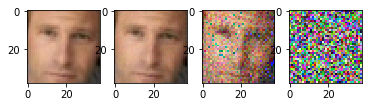

In [37]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0].transpose([1,2,0]))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0].transpose([1,2,0]))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0].transpose([1,2,0]))

In [18]:
inp, encoder, decoder = build_pca_autoencoder(img_shape,code_size=32)

code,reconstruction = L.get_output([encoder,decoder])
loss = T.mean((inp.input_var - reconstruction)**2)
updates = lasagne.updates.adamax(loss,L.get_all_params(decoder,trainable=True))

train_step = theano.function([inp.input_var],loss,updates=updates,allow_input_downcast=True)
compute_loss = theano.function([inp.input_var],loss,allow_input_downcast=True)
encode_decode = theano.function([inp.input_var],[code,reconstruction],allow_input_downcast=True)

In [19]:
for epoch in range(50):
    print("Epoch %i/50, Generating corrupted samples..."%epoch)
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    losses = []
    for x_batch in iterate_minibatches(X_train_noise,batch_size=50):
        losses.append(train_step(x_batch))
    print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)
    
    val_losses = list(map(compute_loss,iterate_minibatches(X_test_noise,verbose=False)))
    print("#%i, Test loss: %.7f"%(epoch+1,np.mean(val_losses)),flush=True)


Epoch 0/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 133.08it/s]

#1, Train loss: 0.0448391
#1, Test loss: 0.0307300


Epoch 1/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 137.62it/s]

#2, Train loss: 0.0294233


#2, Test loss: 0.0281665
Epoch 2/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 139.87it/s]

#3, Train loss: 0.0266371


#3, Test loss: 0.0258643
Epoch 3/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 137.22it/s]

#4, Train loss: 0.0245876


#4, Test loss: 0.0239598
Epoch 4/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 114.52it/s]

#5, Train loss: 0.0229951


#5, Test loss: 0.0226606
Epoch 5/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 100.20it/s]

#6, Train loss: 0.0216850


#6, Test loss: 0.0212662
Epoch 6/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 140.43it/s]

#7, Train loss: 0.0206090


#7, Test loss: 0.0202778
Epoch 7/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 119.02it/s]

#8, Train loss: 0.0197119


#8, Test loss: 0.0194508
Epoch 8/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 135.95it/s]

#9, Train loss: 0.0189463
#9, Test loss: 0.0188104


Epoch 9/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 110.07it/s]

#10, Train loss: 0.0183378


#10, Test loss: 0.0181314
Epoch 10/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 87.23it/s]

#11, Train loss: 0.0177285


#11, Test loss: 0.0174763
Epoch 11/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 150.32it/s]

#12, Train loss: 0.0171725
#12, Test loss: 0.0174921


Epoch 12/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 109.88it/s]

#13, Train loss: 0.0167977


#13, Test loss: 0.0170607
Epoch 13/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 151.23it/s]

#14, Train loss: 0.0163935
#14, Test loss: 0.0163320


Epoch 14/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 155.81it/s]

#15, Train loss: 0.0161087


#15, Test loss: 0.0161387
Epoch 15/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 127.74it/s]

#16, Train loss: 0.0159719
#16, Test loss: 0.0159415


Epoch 16/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 98.73it/s] 

#17, Train loss: 0.0158721


#17, Test loss: 0.0159402
Epoch 17/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 146.29it/s]

#18, Train loss: 0.0158312
#18, Test loss: 0.0159681


Epoch 18/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 126.04it/s]

#19, Train loss: 0.0158000


#19, Test loss: 0.0158527
Epoch 19/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 159.21it/s]

#20, Train loss: 0.0157739


#20, Test loss: 0.0158992
Epoch 20/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 150.14it/s]

#21, Train loss: 0.0157420
#21, Test loss: 0.0158081


Epoch 21/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 159.65it/s]

#22, Train loss: 0.0157095
#22, Test loss: 0.0158338


Epoch 22/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 124.16it/s]

#23, Train loss: 0.0157092


#23, Test loss: 0.0158767
Epoch 23/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 90.12it/s] 

#24, Train loss: 0.0156862
#24, Test loss: 0.0157488


Epoch 24/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 126.20it/s]

#25, Train loss: 0.0156776


#25, Test loss: 0.0156941
Epoch 25/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 143.42it/s]

#26, Train loss: 0.0156720


#26, Test loss: 0.0157233
Epoch 26/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 125.92it/s]

#27, Train loss: 0.0156615
#27, Test loss: 0.0157811


Epoch 27/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 86.27it/s]

#28, Train loss: 0.0156509


#28, Test loss: 0.0158010
Epoch 28/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 116.94it/s]

#29, Train loss: 0.0156208


#29, Test loss: 0.0156904
Epoch 29/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 103.17it/s]

#30, Train loss: 0.0156202


#30, Test loss: 0.0156943
Epoch 30/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 135.45it/s]

#31, Train loss: 0.0156230


#31, Test loss: 0.0158583
Epoch 31/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 107.90it/s]

#32, Train loss: 0.0156071


#32, Test loss: 0.0156735
Epoch 32/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 138.74it/s]

#33, Train loss: 0.0156077


#33, Test loss: 0.0157195
Epoch 33/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 129.82it/s]

#34, Train loss: 0.0155950


#34, Test loss: 0.0156932
Epoch 34/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 138.28it/s]

#35, Train loss: 0.0155905


#35, Test loss: 0.0156299
Epoch 35/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 113.35it/s]

#36, Train loss: 0.0155831
#36, Test loss: 0.0156649


Epoch 36/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 138.05it/s]

#37, Train loss: 0.0155799


#37, Test loss: 0.0157170
Epoch 37/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 138.12it/s]

#38, Train loss: 0.0155631


#38, Test loss: 0.0157658
Epoch 38/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 135.56it/s]

#39, Train loss: 0.0155687
#39, Test loss: 0.0159030


Epoch 39/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 137.75it/s]

#40, Train loss: 0.0155655


#40, Test loss: 0.0156827
Epoch 40/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 129.34it/s]

#41, Train loss: 0.0155408


#41, Test loss: 0.0156639
Epoch 41/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 138.99it/s]

#42, Train loss: 0.0155424


#42, Test loss: 0.0156708
Epoch 42/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 129.89it/s]

#43, Train loss: 0.0155471


#43, Test loss: 0.0156946
Epoch 43/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 135.32it/s]

#44, Train loss: 0.0155404
#44, Test loss: 0.0156932


Epoch 44/50, Generating corrupted samples...


100%|██████████| 237/237 [00:02<00:00, 114.73it/s]

#45, Train loss: 0.0155465


#45, Test loss: 0.0156824
Epoch 45/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 132.84it/s]

#46, Train loss: 0.0155106


#46, Test loss: 0.0156014
Epoch 46/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 133.59it/s]

#47, Train loss: 0.0155431


#47, Test loss: 0.0156746
Epoch 47/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 139.04it/s]

#48, Train loss: 0.0155187


#48, Test loss: 0.0155854
Epoch 48/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 140.39it/s]

#49, Train loss: 0.0155062


#49, Test loss: 0.0155763
Epoch 49/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 136.24it/s]

#50, Train loss: 0.0155191
#50, Test loss: 0.0155842


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.0056470794059


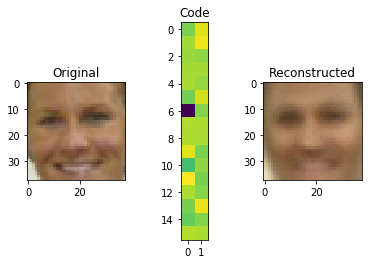

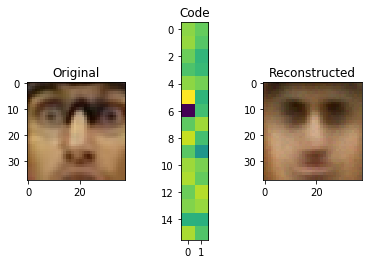

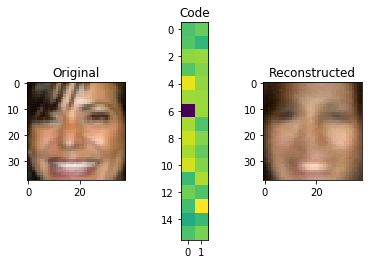

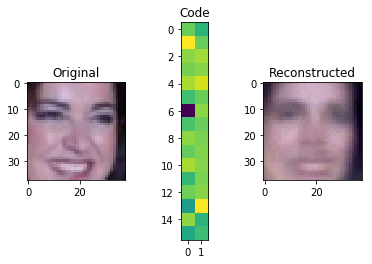

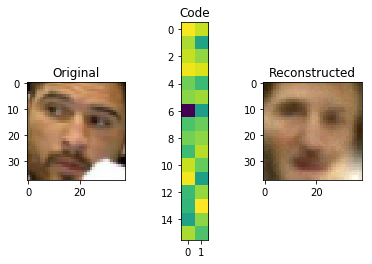

In [20]:
reconstruction_mse = np.mean(list(map(compute_loss,iterate_minibatches(X_test,verbose=False))))
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [21]:
#compile function that encodes batch of images into a batch of vector[batch,code_size]
encode = theano.function([inp.input_var],code,allow_input_downcast=True)
#... and another function that casts those codes back into images
codes = T.matrix("codes")
decode = theano.function([codes],L.get_output(decoder,{encoder:codes}))


In [32]:
images = X_train
codes = encode_decode(images)[0]
assert len(codes) == len(images)

In [26]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

/home/lats/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/approximate.py:220: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [33]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encode_decode(image[None])[0]
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [38]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

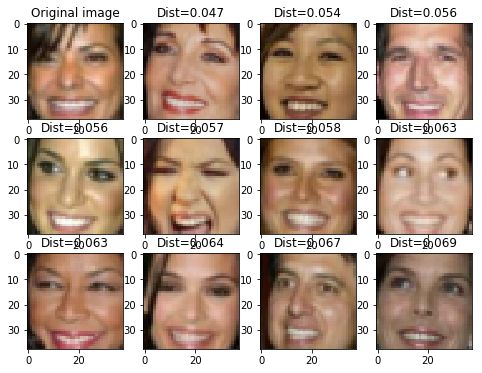

In [39]:
#smiles
show_similar(X_test[2])

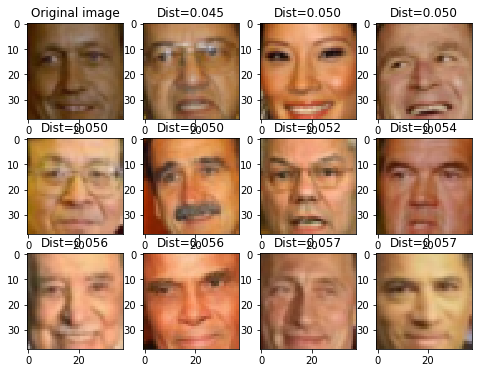

In [40]:
#ethnicity
show_similar(X_test[500])

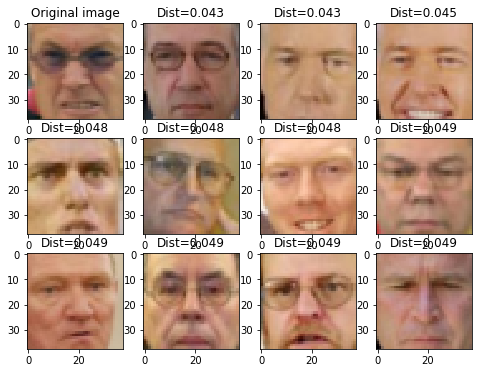

In [41]:
#glasses
show_similar(X_test[66])

## Bonus: cheap image morphing


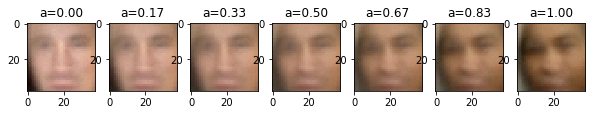

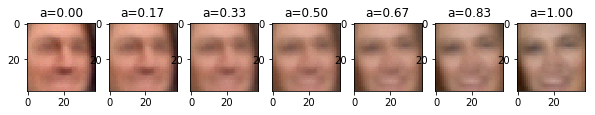

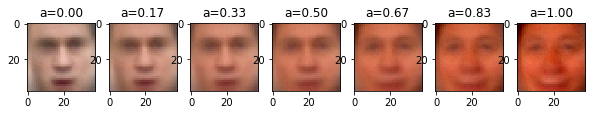

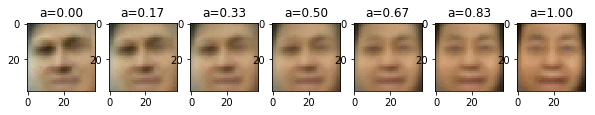

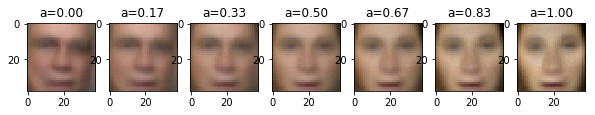

In [42]:

for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encode(np.stack([image1,image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decode(output_code[None])[0]

        plt.subplot(1,7,i+1)
        plt.imshow(output_image.transpose([1,2,0]).clip(0,1))
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.